# Implementation of GAN with R1 Regularizer
Reference: https://arxiv.org/pdf/1801.04406

In [1]:
# Run the comment below only when using Google Colab
# !pip install torch torchvision

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad

In [3]:
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

In [4]:
import numpy as np
import datetime
import os, sys
import glob
from tqdm import tqdm

In [5]:
from PIL import Image

In [6]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [7]:
MODEL_NAME = 'R1'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
IMAGE_DIM = (64, 64, 3)

In [9]:
def tensor2img(tensor):
    img = (np.transpose(tensor.detach().cpu().numpy(), [1,2,0])+1)/2.
    return img

In [10]:
def get_sample_image(G, n_noise=100, n_samples=64):
    """
        save sample 100 images
    """
    n_rows = int(np.sqrt(n_samples))
    z = (torch.rand(size=[n_samples, n_noise])*2-1).to(DEVICE) # U[-1, 1]
    x_fake = G(z)
    x_fake = torch.cat([torch.cat([x_fake[n_rows*j+i] for i in range(n_rows)], dim=1) for j in range(n_rows)], dim=2)
    result = tensor2img(x_fake)
    return result

In [11]:
class ResidualBlock(nn.Module):
    def __init__(self, inplanes, planes, kernel_size=3, stride=1, downsample=None, groups=1):
        super(ResidualBlock, self).__init__()
        p = kernel_size//2
        self.conv1 = nn.Sequential(
            nn.Conv2d(inplanes, planes, kernel_size, stride=stride, padding=p),
            nn.LeakyReLU(0.2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(planes, planes, kernel_size, padding=p),
            nn.LeakyReLU(0.2)
        )
        self.proj = nn.Conv2d(inplanes, planes, 1) if inplanes != planes else None
    
    def forward(self, x):
        identity = x
        
        y = self.conv1(x)
        y = self.conv2(y)
        
        identity = identity if self.proj is None else self.proj(identity)
        y = y + identity
        return y

In [12]:
class Discriminator(nn.Module):
    """
        Convolutional Discriminator
    """
    def __init__(self, in_channel=1):
        super(Discriminator, self).__init__()
        self.D = nn.Sequential(
            nn.Conv2d(in_channel, 64, 3, padding=1), # (N, 64, 64, 64)
            ResidualBlock(64, 128),
            nn.AvgPool2d(3, 2, padding=1), # (N, 128, 32, 32)
            ResidualBlock(128, 256),
            nn.AvgPool2d(3, 2, padding=1), # (N, 256, 16, 16)
            ResidualBlock(256, 512),
            nn.AvgPool2d(3, 2, padding=1), # (N, 512, 8, 8)
            ResidualBlock(512, 1024),
            nn.AvgPool2d(3, 2, padding=1) # (N, 1024, 4, 4)
        )
        self.fc = nn.Linear(1024*4*4, 1) # (N, 1)
        
    def forward(self, x):
        B = x.size(0)
        h = self.D(x)
        h = h.view(B, -1)
        y = self.fc(h)
        return y

In [13]:
class Generator(nn.Module):
    """
        Convolutional Generator
    """
    def __init__(self, out_channel=1, n_filters=128, n_noise=512):
        super(Generator, self).__init__()
        self.fc = nn.Linear(n_noise, 1024*4*4)
        self.G = nn.Sequential(
            ResidualBlock(1024, 512),
            nn.Upsample(scale_factor=2, mode='bilinear'), # (N, 512, 8, 8)
            ResidualBlock(512, 256),
            nn.Upsample(scale_factor=2, mode='bilinear'), # (N, 256, 16, 16)
            ResidualBlock(256, 128),
            nn.Upsample(scale_factor=2, mode='bilinear'), # (N, 128, 32, 32)
            ResidualBlock(128, 64),
            nn.Upsample(scale_factor=2, mode='bilinear'), # (N, 64, 64, 64)
            ResidualBlock(64, 64),
            nn.Conv2d(64, out_channel, 3, padding=1) # (N, 3, 64, 64)
        )
        
    def forward(self, z):
        B = z.size(0)
        h = self.fc(z)
        h = h.view(B, 1024, 4, 4)
        x = self.G(h)
        return x

In [14]:
transform = transforms.Compose([transforms.Resize((IMAGE_DIM[0],IMAGE_DIM[1])),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5),
                                std=(0.5, 0.5, 0.5))
                               ]
)

CelebA-aligned download: [link](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)

In [15]:
dataset = datasets.ImageFolder(root='/home/yangyangii/data/img_align_celeba', transform=transform)

In [16]:
batch_size = 64
n_noise = 256

In [17]:
data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4, pin_memory=True)

In [18]:
D = Discriminator(in_channel=IMAGE_DIM[-1]).to(DEVICE)
G = Generator(out_channel=IMAGE_DIM[-1], n_noise=n_noise).to(DEVICE)

In [19]:
D_opt = torch.optim.RMSprop(D.parameters(), lr=1e-4, alpha=0.99)
G_opt = torch.optim.RMSprop(G.parameters(), lr=1e-4, alpha=0.99)

In [20]:
# D_scheduler = torch.optim.lr_scheduler.MultiStepLR(D_opt, milestones=[3, 10, 17], gamma=0.6)
# G_scheduler = torch.optim.lr_scheduler.MultiStepLR(G_opt, milestones=[3, 10, 17], gamma=0.6)

In [21]:
# criterion = nn.L1Loss()
def r1loss(inputs, label=None):
    # non-saturating loss with R1 regularization
    l = -1 if label else 1
    return F.softplus(l*inputs).mean()

In [22]:
max_epoch = 20
step = 0

In [23]:
log_term = 1000
save_term = 1000

In [24]:
r1_gamma = 10

In [25]:
steps_per_epoch = len(data_loader.dataset) // batch_size
steps_per_epoch

3165

In [26]:
if not os.path.exists('samples'):
    os.makedirs('samples')
    
if not os.path.exists('ckpt'):
    os.makedirs('ckpt')

In [27]:
def save_checkpoint(state, file_name='checkpoint.pth.tar'):
    torch.save(state, file_name)

In [28]:
for epoch in range(max_epoch):
    for idx, (images, labels) in enumerate(tqdm(data_loader, total=len(data_loader))):
        G.zero_grad()
        # Training Discriminator
        x = images.to(DEVICE)
        x.requires_grad = True
        x_outputs = D(x)
        d_real_loss = r1loss(x_outputs, True)
        # Reference >> https://github.com/rosinality/style-based-gan-pytorch/blob/a3d000e707b70d1a5fc277912dc9d7432d6e6069/train.py
        # little different with original DiracGAN
        grad_real = grad(outputs=x_outputs.sum(), inputs=x, create_graph=True)[0]
        grad_penalty = (grad_real.view(grad_real.size(0), -1).norm(2, dim=1) ** 2).mean()
        grad_penalty = 0.5*r1_gamma*grad_penalty
        D_x_loss = d_real_loss + grad_penalty

        z = (torch.rand(size=[batch_size, n_noise])*2-1).to(DEVICE)
        x_fake = G(z)
        z_outputs = D(x_fake.detach())
        D_z_loss = r1loss(z_outputs, False)
        D_loss = D_x_loss + D_z_loss
        
        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        # Training Generator
        z = (torch.rand(size=[batch_size, n_noise])*2-1).to(DEVICE)
        x_fake = G(z)
        z_outputs = D(x_fake)
        G_loss = r1loss(z_outputs, True)
        
        G.zero_grad()
        G_loss.backward()
        G_opt.step()
        
        if step % save_term == 0:
            save_checkpoint({'global_step': step,
                 'D':D.state_dict(),
                 'G':G.state_dict(),
                 'd_optim': D_opt.state_dict(),
                 'g_optim' : G_opt.state_dict()},
                'ckpt/r1gan{:06d}.pth.tar'.format(step))
        
        if step % log_term == 0:
            dt = datetime.datetime.now().strftime('%H:%M:%S')
            print('Epoch: {}/{}, Step: {}, D Loss: {:.4f}, G Loss: {:.4f}, gp: {:.4f}, Time:{}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item(), grad_penalty.item(), dt))
            G.eval()
            img = get_sample_image(G, n_noise, n_samples=25)
            imsave('samples/{}_step{:06d}.jpg'.format(MODEL_NAME, step), img)
            G.train()
        
        step += 1
#     D_scheduler.step()
#     G_scheduler.step()

  0%|          | 0/3165 [00:00<?, ?it/s]/home/yangyangii/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
  0%|          | 1/3165 [00:02<1:50:36,  2.10s/it]

Epoch: 0/20, Step: 0, D Loss: 1.3870, G Loss: 0.2449, gp: 0.0000, Time:20:31:40


 32%|███▏      | 1001/3165 [09:43<30:58,  1.16it/s]

Epoch: 0/20, Step: 1000, D Loss: 1.1092, G Loss: 1.6125, gp: 0.0898, Time:20:41:21


 63%|██████▎   | 2001/3165 [19:27<16:33,  1.17it/s]

Epoch: 0/20, Step: 2000, D Loss: 1.3559, G Loss: 0.7619, gp: 0.0745, Time:20:51:06


 95%|█████████▍| 3001/3165 [29:10<02:21,  1.16it/s]

Epoch: 0/20, Step: 3000, D Loss: 1.2636, G Loss: 1.0919, gp: 0.0731, Time:21:00:48


 26%|██▋       | 836/3165 [08:02<33:03,  1.17it/s]

Epoch: 1/20, Step: 4000, D Loss: 1.2924, G Loss: 1.0724, gp: 0.0674, Time:21:10:30


 58%|█████▊    | 1836/3165 [17:44<18:57,  1.17it/s]

Epoch: 1/20, Step: 5000, D Loss: 1.3173, G Loss: 0.7331, gp: 0.0623, Time:21:20:12


 90%|████████▉ | 2836/3165 [27:34<04:44,  1.16it/s]

Epoch: 1/20, Step: 6000, D Loss: 1.3076, G Loss: 1.1029, gp: 0.0592, Time:21:30:01


 21%|██        | 671/3165 [06:38<36:14,  1.15it/s]

Epoch: 2/20, Step: 7000, D Loss: 1.3023, G Loss: 0.7380, gp: 0.0463, Time:21:39:56


 53%|█████▎    | 1671/3165 [16:29<20:55,  1.19it/s]

Epoch: 2/20, Step: 8000, D Loss: 1.3092, G Loss: 0.7779, gp: 0.0452, Time:21:49:46


 84%|████████▍ | 2671/3165 [26:16<07:15,  1.13it/s]

Epoch: 2/20, Step: 9000, D Loss: 1.3523, G Loss: 0.7543, gp: 0.0392, Time:21:59:33


 16%|█▌        | 506/3165 [04:57<38:33,  1.15it/s]

Epoch: 3/20, Step: 10000, D Loss: 1.3159, G Loss: 0.8721, gp: 0.0440, Time:22:09:22


 48%|████▊     | 1506/3165 [14:53<22:47,  1.21it/s]

Epoch: 3/20, Step: 11000, D Loss: 1.3277, G Loss: 0.7147, gp: 0.0387, Time:22:19:17


 79%|███████▉  | 2506/3165 [24:44<10:14,  1.07it/s]

Epoch: 3/20, Step: 12000, D Loss: 1.3454, G Loss: 0.8033, gp: 0.0332, Time:22:29:09


 11%|█         | 341/3165 [03:24<42:15,  1.11it/s]

Epoch: 4/20, Step: 13000, D Loss: 1.3386, G Loss: 0.8169, gp: 0.0365, Time:22:39:11


 42%|████▏     | 1341/3165 [13:07<25:32,  1.19it/s]

Epoch: 4/20, Step: 14000, D Loss: 1.3391, G Loss: 0.7094, gp: 0.0357, Time:22:48:54


 74%|███████▍  | 2341/3165 [22:43<11:31,  1.19it/s]

Epoch: 4/20, Step: 15000, D Loss: 1.3601, G Loss: 0.8294, gp: 0.0337, Time:22:58:30


  6%|▌         | 176/3165 [01:42<42:45,  1.16it/s]

Epoch: 5/20, Step: 16000, D Loss: 1.3414, G Loss: 0.6806, gp: 0.0293, Time:23:08:06


 37%|███▋      | 1176/3165 [11:18<28:20,  1.17it/s]

Epoch: 5/20, Step: 17000, D Loss: 1.3623, G Loss: 0.6395, gp: 0.0305, Time:23:17:42


 69%|██████▉   | 2176/3165 [20:53<14:17,  1.15it/s]

Epoch: 5/20, Step: 18000, D Loss: 1.3550, G Loss: 0.8261, gp: 0.0313, Time:23:27:18


  0%|          | 11/3165 [00:07<44:38,  1.18it/s]

Epoch: 6/20, Step: 19000, D Loss: 1.3565, G Loss: 0.6988, gp: 0.0280, Time:23:36:54


 32%|███▏      | 1011/3165 [09:43<30:20,  1.18it/s]

Epoch: 6/20, Step: 20000, D Loss: 1.3445, G Loss: 0.8188, gp: 0.0296, Time:23:46:30


 64%|██████▎   | 2011/3165 [19:19<16:11,  1.19it/s]

Epoch: 6/20, Step: 21000, D Loss: 1.3538, G Loss: 0.8031, gp: 0.0261, Time:23:56:06


 95%|█████████▌| 3011/3165 [28:55<02:09,  1.19it/s]

Epoch: 6/20, Step: 22000, D Loss: 1.3591, G Loss: 0.7518, gp: 0.0272, Time:00:05:41


 27%|██▋       | 846/3165 [08:07<32:38,  1.18it/s]

Epoch: 7/20, Step: 23000, D Loss: 1.3480, G Loss: 0.7632, gp: 0.0263, Time:00:15:17


 58%|█████▊    | 1846/3165 [17:43<18:28,  1.19it/s]

Epoch: 7/20, Step: 24000, D Loss: 1.3679, G Loss: 0.7949, gp: 0.0252, Time:00:24:53


 90%|████████▉ | 2846/3165 [27:19<04:33,  1.17it/s]

Epoch: 7/20, Step: 25000, D Loss: 1.3663, G Loss: 0.7966, gp: 0.0259, Time:00:34:29


 22%|██▏       | 681/3165 [06:32<34:33,  1.20it/s]

Epoch: 8/20, Step: 26000, D Loss: 1.3742, G Loss: 0.7697, gp: 0.0258, Time:00:44:05


 53%|█████▎    | 1681/3165 [16:08<20:57,  1.18it/s]

Epoch: 8/20, Step: 27000, D Loss: 1.3828, G Loss: 0.8241, gp: 0.0280, Time:00:53:41


 85%|████████▍ | 2681/3165 [25:44<06:47,  1.19it/s]

Epoch: 8/20, Step: 28000, D Loss: 1.3631, G Loss: 0.7895, gp: 0.0252, Time:01:03:17


 16%|█▋        | 516/3165 [04:57<37:28,  1.18it/s]

Epoch: 9/20, Step: 29000, D Loss: 1.3771, G Loss: 0.7927, gp: 0.0263, Time:01:12:53


 48%|████▊     | 1516/3165 [14:33<23:03,  1.19it/s]

Epoch: 9/20, Step: 30000, D Loss: 1.3567, G Loss: 0.8071, gp: 0.0227, Time:01:22:29


 79%|███████▉  | 2516/3165 [24:09<09:03,  1.19it/s]

Epoch: 9/20, Step: 31000, D Loss: 1.3666, G Loss: 0.7239, gp: 0.0230, Time:01:32:04


 11%|█         | 351/3165 [03:22<39:32,  1.19it/s]

Epoch: 10/20, Step: 32000, D Loss: 1.3703, G Loss: 0.7561, gp: 0.0239, Time:01:41:40


 43%|████▎     | 1351/3165 [12:58<25:25,  1.19it/s]

Epoch: 10/20, Step: 33000, D Loss: 1.3652, G Loss: 0.7242, gp: 0.0248, Time:01:51:16


 74%|███████▍  | 2351/3165 [22:34<10:57,  1.24it/s]

Epoch: 10/20, Step: 34000, D Loss: 1.3632, G Loss: 0.7361, gp: 0.0223, Time:02:00:52


  6%|▌         | 186/3165 [01:47<42:10,  1.18it/s]

Epoch: 11/20, Step: 35000, D Loss: 1.3538, G Loss: 0.7366, gp: 0.0243, Time:02:10:27


 37%|███▋      | 1186/3165 [11:23<28:26,  1.16it/s]

Epoch: 11/20, Step: 36000, D Loss: 1.3665, G Loss: 0.7475, gp: 0.0233, Time:02:20:03


 69%|██████▉   | 2186/3165 [20:59<13:47,  1.18it/s]

Epoch: 11/20, Step: 37000, D Loss: 1.3512, G Loss: 0.7080, gp: 0.0216, Time:02:29:39


  1%|          | 21/3165 [00:13<45:06,  1.16it/s]

Epoch: 12/20, Step: 38000, D Loss: 1.3551, G Loss: 0.8267, gp: 0.0214, Time:02:39:15


 32%|███▏      | 1021/3165 [09:48<30:15,  1.18it/s]

Epoch: 12/20, Step: 39000, D Loss: 1.3629, G Loss: 0.7281, gp: 0.0207, Time:02:48:51


 64%|██████▍   | 2021/3165 [19:24<16:05,  1.18it/s]

Epoch: 12/20, Step: 40000, D Loss: 1.3605, G Loss: 0.7544, gp: 0.0211, Time:02:58:26


 95%|█████████▌| 3021/3165 [29:00<02:03,  1.17it/s]

Epoch: 12/20, Step: 41000, D Loss: 1.3604, G Loss: 0.7265, gp: 0.0222, Time:03:08:02


 27%|██▋       | 856/3165 [08:13<32:59,  1.17it/s]

Epoch: 13/20, Step: 42000, D Loss: 1.3704, G Loss: 0.7504, gp: 0.0215, Time:03:17:38


 59%|█████▊    | 1856/3165 [17:48<18:49,  1.16it/s]

Epoch: 13/20, Step: 43000, D Loss: 1.3632, G Loss: 0.6863, gp: 0.0201, Time:03:27:13


 90%|█████████ | 2856/3165 [27:24<04:21,  1.18it/s]

Epoch: 13/20, Step: 44000, D Loss: 1.3593, G Loss: 0.7309, gp: 0.0204, Time:03:36:49


 22%|██▏       | 691/3165 [06:38<35:36,  1.16it/s]

Epoch: 14/20, Step: 45000, D Loss: 1.3681, G Loss: 0.7237, gp: 0.0206, Time:03:46:25


 53%|█████▎    | 1691/3165 [16:13<20:42,  1.19it/s]

Epoch: 14/20, Step: 46000, D Loss: 1.3552, G Loss: 0.6982, gp: 0.0217, Time:03:56:00


 85%|████████▌ | 2691/3165 [25:49<06:42,  1.18it/s]

Epoch: 14/20, Step: 47000, D Loss: 1.3672, G Loss: 0.7450, gp: 0.0194, Time:04:05:36


 17%|█▋        | 526/3165 [05:03<37:11,  1.18it/s]

Epoch: 15/20, Step: 48000, D Loss: 1.3509, G Loss: 0.7255, gp: 0.0180, Time:04:15:12


 48%|████▊     | 1526/3165 [14:38<23:11,  1.18it/s]

Epoch: 15/20, Step: 49000, D Loss: 1.3638, G Loss: 0.7127, gp: 0.0200, Time:04:24:47


 80%|███████▉  | 2526/3165 [24:14<09:14,  1.15it/s]

Epoch: 15/20, Step: 50000, D Loss: 1.3605, G Loss: 0.6794, gp: 0.0206, Time:04:34:23


 11%|█▏        | 361/3165 [03:28<39:56,  1.17it/s]

Epoch: 16/20, Step: 51000, D Loss: 1.3631, G Loss: 0.7023, gp: 0.0230, Time:04:43:59


 43%|████▎     | 1361/3165 [13:04<26:01,  1.16it/s]

Epoch: 16/20, Step: 52000, D Loss: 1.3594, G Loss: 0.7142, gp: 0.0202, Time:04:53:34


 75%|███████▍  | 2361/3165 [22:39<11:21,  1.18it/s]

Epoch: 16/20, Step: 53000, D Loss: 1.3643, G Loss: 0.7219, gp: 0.0196, Time:05:03:10


  6%|▌         | 196/3165 [01:53<42:27,  1.17it/s]

Epoch: 17/20, Step: 54000, D Loss: 1.3733, G Loss: 0.6913, gp: 0.0181, Time:05:12:45


 38%|███▊      | 1196/3165 [11:29<28:03,  1.17it/s]

Epoch: 17/20, Step: 55000, D Loss: 1.3637, G Loss: 0.7407, gp: 0.0183, Time:05:22:21


 69%|██████▉   | 2196/3165 [21:05<13:41,  1.18it/s]

Epoch: 17/20, Step: 56000, D Loss: 1.3625, G Loss: 0.6899, gp: 0.0213, Time:05:31:57


  1%|          | 31/3165 [00:18<45:22,  1.15it/s]

Epoch: 18/20, Step: 57000, D Loss: 1.3635, G Loss: 0.7808, gp: 0.0193, Time:05:41:33


 33%|███▎      | 1031/3165 [09:54<30:18,  1.17it/s]

Epoch: 18/20, Step: 58000, D Loss: 1.3665, G Loss: 0.7458, gp: 0.0200, Time:05:51:08


 64%|██████▍   | 2031/3165 [19:30<16:15,  1.16it/s]

Epoch: 18/20, Step: 59000, D Loss: 1.3674, G Loss: 0.6838, gp: 0.0168, Time:06:00:44


 96%|█████████▌| 3031/3165 [29:06<01:53,  1.18it/s]

Epoch: 18/20, Step: 60000, D Loss: 1.3675, G Loss: 0.7181, gp: 0.0170, Time:06:10:20


 27%|██▋       | 866/3165 [08:19<32:46,  1.17it/s]

Epoch: 19/20, Step: 61000, D Loss: 1.3638, G Loss: 0.7626, gp: 0.0194, Time:06:19:56


 59%|█████▉    | 1866/3165 [17:55<18:26,  1.17it/s]

Epoch: 19/20, Step: 62000, D Loss: 1.3744, G Loss: 0.7093, gp: 0.0200, Time:06:29:32


 91%|█████████ | 2866/3165 [27:31<04:15,  1.17it/s]

Epoch: 19/20, Step: 63000, D Loss: 1.3639, G Loss: 0.7109, gp: 0.0184, Time:06:39:08


100%|██████████| 3165/3165 [30:22<00:00,  1.74it/s]


In [30]:
save_checkpoint({'global_step': step,
     'D':D.state_dict(),
     'G':G.state_dict(),
     'd_optim': D_opt.state_dict(),
     'g_optim' : G_opt.state_dict()},
    'ckpt/r1gan{:06d}.pth.tar'.format(step))

### Random Sample

In [39]:
G_path = sorted(glob.glob(os.path.join('ckpt', '*.pth.tar')))[-1]
state = torch.load(G_path)
G.load_state_dict(state['G'])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [41]:
G.eval()
None

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


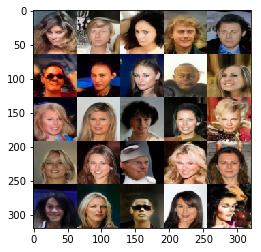

In [42]:
img = get_sample_image(G, n_noise, n_samples=25)
imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


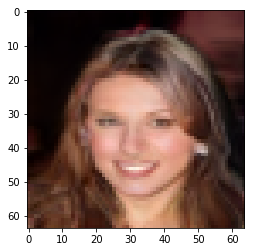

In [52]:
# Fake Image
idx = [3, 1]
row, col = IMAGE_DIM[0]*idx[0], IMAGE_DIM[1]*idx[1]
imshow(img[row:row+IMAGE_DIM[0], col:col+IMAGE_DIM[1], :])

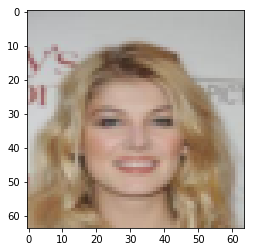

In [44]:
# Real Image
i = 14
rimg = tensor2img(images[i])
imshow(rimg)

### Interpolation

In [53]:
def sample_noise(size=None):
    z = np.random.random(size=size)*2-1
    return z

In [76]:
z_a, z_b = sample_noise(n_noise), sample_noise(n_noise)
zs = torch.tensor([np.linspace(z_a[i], z_b[i], num=10) for i in range(n_noise)], dtype=torch.float32).to(DEVICE)
zs = torch.transpose(zs, 0, 1)
zs.shape

torch.Size([10, 256])

In [77]:
imgs = G(zs).detach()
imgs = torch.cat([imgs[i] for i in range(10)], dim=-1)
imgs.shape

torch.Size([3, 64, 640])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


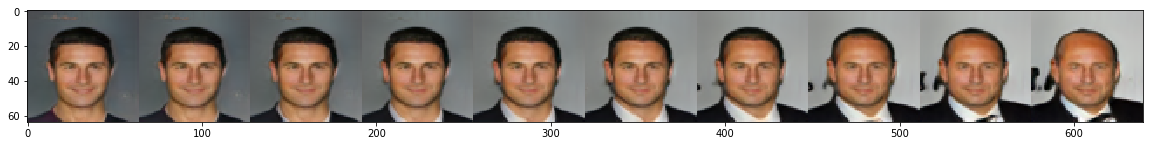

In [78]:
fig = plt.figure(figsize=(20, 3))
imshow(tensor2img(imgs))